In [58]:
import pandas as pd
import numpy as np

In [59]:
data = pd.read_pickle('Data/data_with_embeddings.pkl')

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6922 entries, 0 to 6921
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Authors              6921 non-null   object
 1   Author full names    6921 non-null   object
 2   Author(s) ID         6921 non-null   object
 3   Title                6922 non-null   object
 4   Year                 6922 non-null   int64 
 5   Source title         5604 non-null   object
 6   Link                 6922 non-null   object
 7   Abstract             6922 non-null   object
 8   Author Keywords      6565 non-null   object
 9   Index Keywords       6026 non-null   object
 10  References           6889 non-null   object
 11  DOI                  5688 non-null   object
 12  Open Access          1585 non-null   object
 13  Abstract_Embeddings  6922 non-null   object
dtypes: int64(1), object(13)
memory usage: 757.2+ KB


In [61]:
abstract_embeddings = np.array(data['Abstract_Embeddings'].tolist())

In [62]:
abstract_embeddings[0]

array([ 2.91064437e-02, -7.62963817e-02,  4.20839339e-02,  4.84503098e-02,
       -2.00070534e-03, -2.13739499e-02, -1.41434688e-02, -2.32195314e-02,
       -4.67435867e-02, -6.70728609e-02, -9.76361409e-02, -2.37458386e-03,
       -7.44947325e-03, -3.42071280e-02, -4.91148718e-02, -1.70286652e-02,
        1.14309005e-01,  8.47705752e-02, -5.46772331e-02, -1.90031976e-02,
        4.66363467e-02,  3.32909934e-02,  5.73712168e-03,  7.62886848e-05,
        7.61895478e-02,  6.26350120e-02, -5.45382872e-02,  3.68944444e-02,
        2.39530224e-02, -2.03591455e-02,  7.31803700e-02, -3.06071900e-02,
        5.93889132e-02, -3.39932963e-02, -8.17825273e-02, -1.13139823e-02,
        5.17534511e-03, -8.70065093e-02, -1.85869429e-02, -5.53676002e-02,
       -1.02723904e-01,  2.65228134e-02,  2.24277880e-02, -2.97317300e-02,
        1.91485137e-02, -1.05907461e-02,  2.22058482e-02, -1.67517751e-01,
       -1.31120617e-02, -1.29175792e-02,  6.79214373e-02,  9.25597642e-03,
        1.15954634e-02,  

In [63]:
print(abstract_embeddings.shape, abstract_embeddings.ndim, abstract_embeddings.dtype, abstract_embeddings.size)


(6922, 384) 2 float64 2658048


In [64]:
from sklearn.preprocessing import normalize

In [65]:
normalize_embeddings = normalize(abstract_embeddings)

In [66]:
from sklearn.cluster import KMeans

In [67]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10, max_iter=300)
kmeans.fit(normalize_embeddings)
categories = kmeans.labels_

In [68]:
print(np.unique(categories, return_counts=True))

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([ 976, 1098,  853, 1417, 1542, 1036]))


In [69]:
from sklearn.decomposition import PCA

In [70]:
pca = PCA(n_components=2)

In [71]:
embeddings_2d = pca.fit_transform(normalize_embeddings)

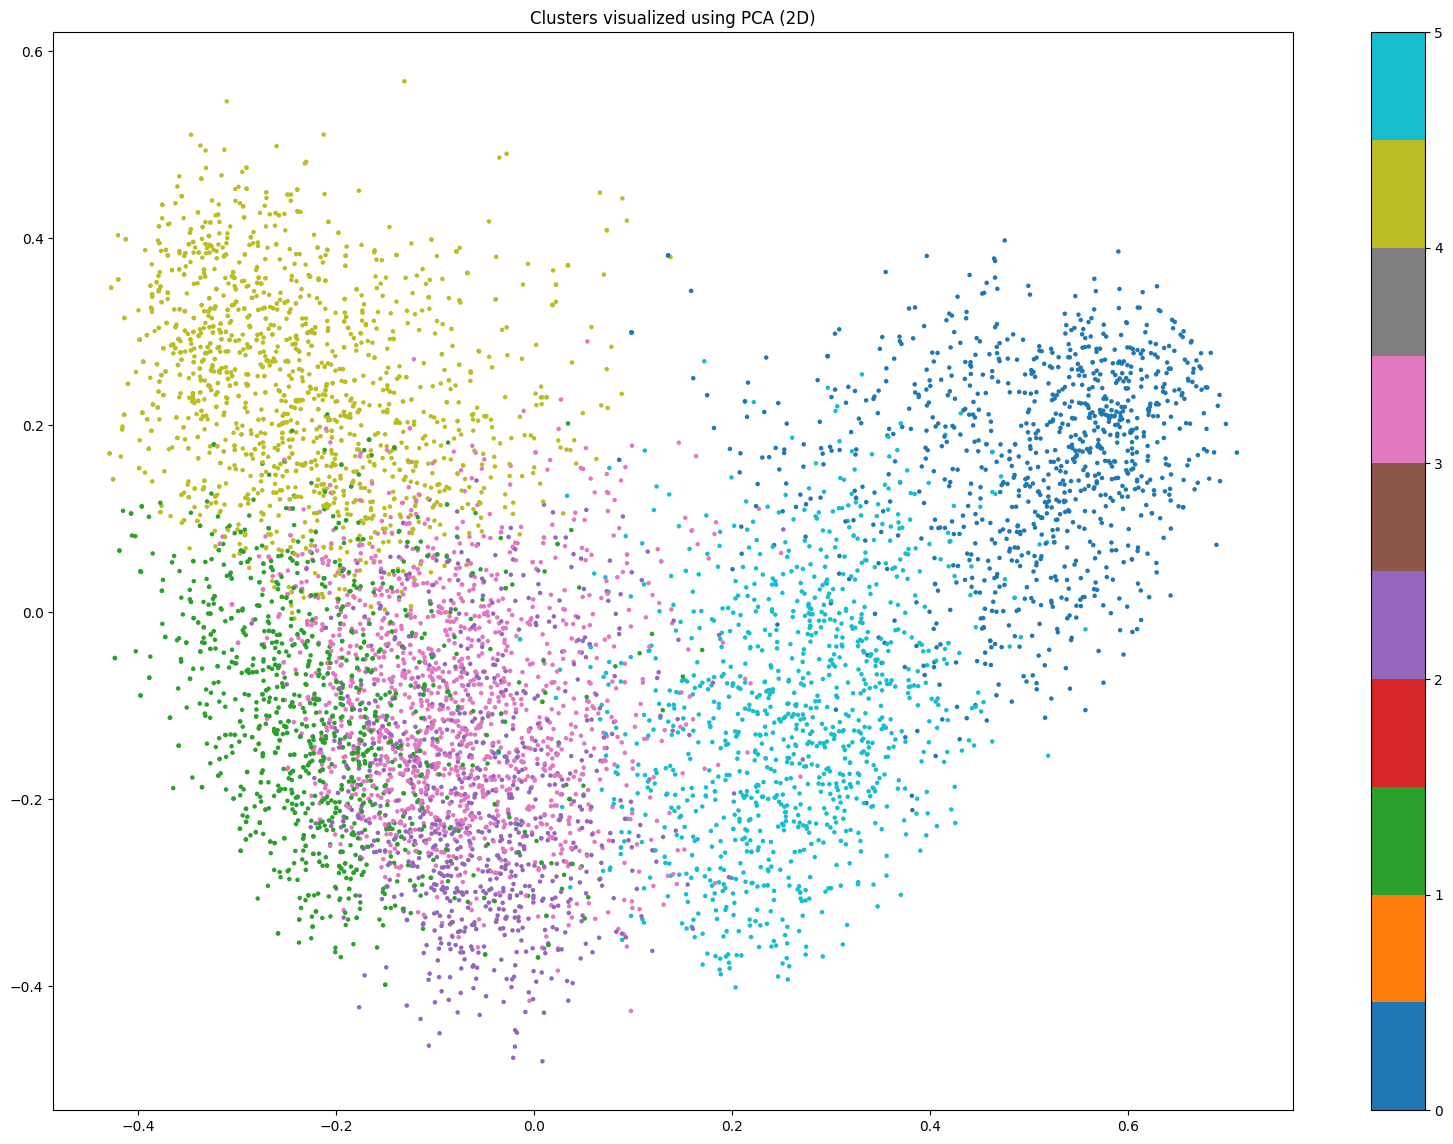

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 14))
plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=categories.astype(float),  # Ensure categories are float
    cmap='tab10',
    s=5
)

plt.title("Clusters visualized using PCA (2D)")
plt.colorbar()
plt.show()


In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['Abstract'].tolist())
feature_names = vectorizer.get_feature_names_out()

In [74]:
cluster_keywords = {}

for cluster_id in np.unique(categories):
    indices = np.where(categories == cluster_id)[0]  
    cluster_tfidf = tfidf_matrix[indices].mean(axis=0).A1  
    top_indices = cluster_tfidf.argsort()[-10:][::-1]
    keywords = [feature_names[i] for i in top_indices]
    cluster_keywords[cluster_id] = keywords   

In [75]:
for cluster_id, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_id}: {keywords}")

Cluster 0: ['concrete', 'learning', 'models', 'machine', 'strength', 'model', 'ml', 'data', 'prediction', 'compressive']
Cluster 1: ['sandwich', 'core', 'panels', 'impact', 'panel', 'honeycomb', 'energy', 'foam', 'face', 'damage']
Cluster 2: ['composite', 'impact', 'damage', 'energy', 'composites', 'ballistic', 'fiber', 'fabric', 'laminates', 'absorption']
Cluster 3: ['energy', 'tubes', 'impact', 'absorption', 'tube', 'structure', 'crashworthiness', 'design', 'crash', 'force']
Cluster 4: ['honeycomb', 'energy', 'structure', 'structures', 'absorption', 'honeycombs', 'auxetic', 'cell', 'impact', 'stress']
Cluster 5: ['concrete', 'strength', 'steel', 'impact', 'fibers', 'fiber', 'strain', 'reinforced', 'energy', 'dynamic']


In [76]:
cluster_names = {
    0: "Concrete Strength Prediction / ML",
    1: "Sandwich Panels & Impact Analysis",
    2: "Composite Materials & Impact",
    3: "Crashworthiness / Energy Absorption",
    4: "Honeycomb Structures & Energy Absorption",
    5: "Reinforced Concrete & Impact"
}

# Add names to your DataFrame
data['Cluster_ID'] = categories
data['Category'] = data['Cluster_ID'].map(cluster_names)


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6922 entries, 0 to 6921
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Authors              6921 non-null   object
 1   Author full names    6921 non-null   object
 2   Author(s) ID         6921 non-null   object
 3   Title                6922 non-null   object
 4   Year                 6922 non-null   int64 
 5   Source title         5604 non-null   object
 6   Link                 6922 non-null   object
 7   Abstract             6922 non-null   object
 8   Author Keywords      6565 non-null   object
 9   Index Keywords       6026 non-null   object
 10  References           6889 non-null   object
 11  DOI                  5688 non-null   object
 12  Open Access          1585 non-null   object
 13  Abstract_Embeddings  6922 non-null   object
 14  Cluster_ID           6922 non-null   int32 
 15  Category             6922 non-null   object
dtypes: int

In [83]:
import re

# Function to clean Excel sheet names
def clean_sheet_name(name):
    # Remove invalid characters and truncate to 31 chars
    cleaned = re.sub(r'[:\\/*?\[\]]', '', str(name))
    return cleaned[:31]

# Export to Excel with sanitized sheet names
with pd.ExcelWriter('Final Database.xlsx', engine='xlsxwriter') as writer:
    for category in data['Category'].unique():
        category_df = data[data['Category'] == category]
        sheet_name = clean_sheet_name(category)
        category_df.to_excel(writer, sheet_name=sheet_name, index=False)
